# 📊 Forecasting Migration Flows — Exploratory Data Analysis (EDA)

**Author:** _Golib Sanaev_

**Last Updated:** _2025-10-08_

**Project:** Forecasting Migration Flows with Machine Learning  
_Notebook: 02-eda_updated.ipynb_

---

### 🎯 **Purpose**

This notebook presents a **clean, presentation-ready EDA** on the cleaned datasets
produced in [`01_data_preparation_and_cleaning.ipynb`](01_data_preparation_and_cleaning.ipynb).
The focus is to tell a clear story about global migration patterns:

- Visualize indicator distributions and highlight skewness.
- Deep-dive into the **target**: Net Migration (per 1,000 people).
- Compare **global**, **regional/aggregate**, and **country** dynamics.
- Reveal relationships via a correlation heatmap and ranked associations.

> This version is optimized for **final presentation**: clean visuals, minimal debug output, and concise text.

In [1]:
# # --- Optional CSS styling for exported HTML/PDF ---
# from IPython.display import HTML
# HTML("""
# <style>
# h2, h3 { color: #2a4d69; }
# blockquote { background-color: #f9f9f9; border-left: 4px solid #2a4d69; padding: 0.6em; }
# </style>
# """)

### 📑 **Table of Contents**

1. [Setup and Load Clean Data](#1-setup-and-load-clean-data)  
2. [Indicator Distributions](#2-indicator-distributions)  
3. [Focus on Net Migration (per 1,000 People)](#3-focus-on-net-migration-per-1000-people)  
 3.1. [Distribution of Net Migration Rates](#31-distribution-of-net-migration-rates)  
 3.2. [Global Trend Over Time](#32-global-trend-over-time)  
 3.3. [Country-Level Variation](#33-country-level-variation)  
 3.4. [Top Migration Inflows and Outflows (Average 1990–2023)](#34-top-migration-inflows-and-outflows-average-1990–2023)  
4. [Global vs Regional Migration Trends](#4-global-vs-regional-migration-trends)  
5. [Correlation and Feature Relationships](#5-correlation-and-feature-relationships)  
 5.1. [Heatmap of Key Correlations](#51-heatmap-of-key-correlations)  
 5.2. [Top Associations with Net Migration](#52-top-associations-with-net-migration)  
6. [Country-Level Trends](#6-country-level-trends)  
7. [Key Insights Summary](#7-key-insights-summary)

---

## 1. Setup and Load Clean Data

In [2]:
# --- Imports & global style ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({"figure.facecolor": "white", "axes.facecolor": "white", 
                     "axes.edgecolor": "gray", "grid.alpha": 0.3, 
                     "axes.titlesize": 12, "axes.labelsize": 11})

In [3]:
# --- Load cleaned datasets ---
DATA_DIR = Path("../data/processed")
df_country = pd.read_csv(DATA_DIR / "countries_clean.csv")
df_agg = pd.read_csv(DATA_DIR / "aggregates_clean.csv")

# Defensive cleanup: ensure helper flags are not present
for d in (df_country, df_agg):
    if "is_aggregate" in d.columns:
        d.drop(columns="is_aggregate", inplace=True)

# Ensure target variable exists and is standardized
if "net_migration_per_1000" not in df_country.columns and {"net_migration", "population"}.issubset(df_country.columns):
    df_country["net_migration_per_1000"] = (df_country["net_migration"] / df_country["population"]) * 1000
if "net_migration_per_1000" not in df_agg.columns and {"net_migration", "population"}.issubset(df_agg.columns):
    df_agg["net_migration_per_1000"] = (df_agg["net_migration"] / df_agg["population"]) * 1000

# Drop absolute net_migration for clarity in EDA (optional)
for d in (df_country, df_agg):
    if "net_migration" in d.columns:
        d.drop(columns="net_migration", inplace=True)

df_country.shape, df_agg.shape

((5712, 19), (1496, 18))

---

## 2. Indicator Distributions

> We examine the distribution of all numeric indicators to understand baseline scales, skewness, and potential outliers.

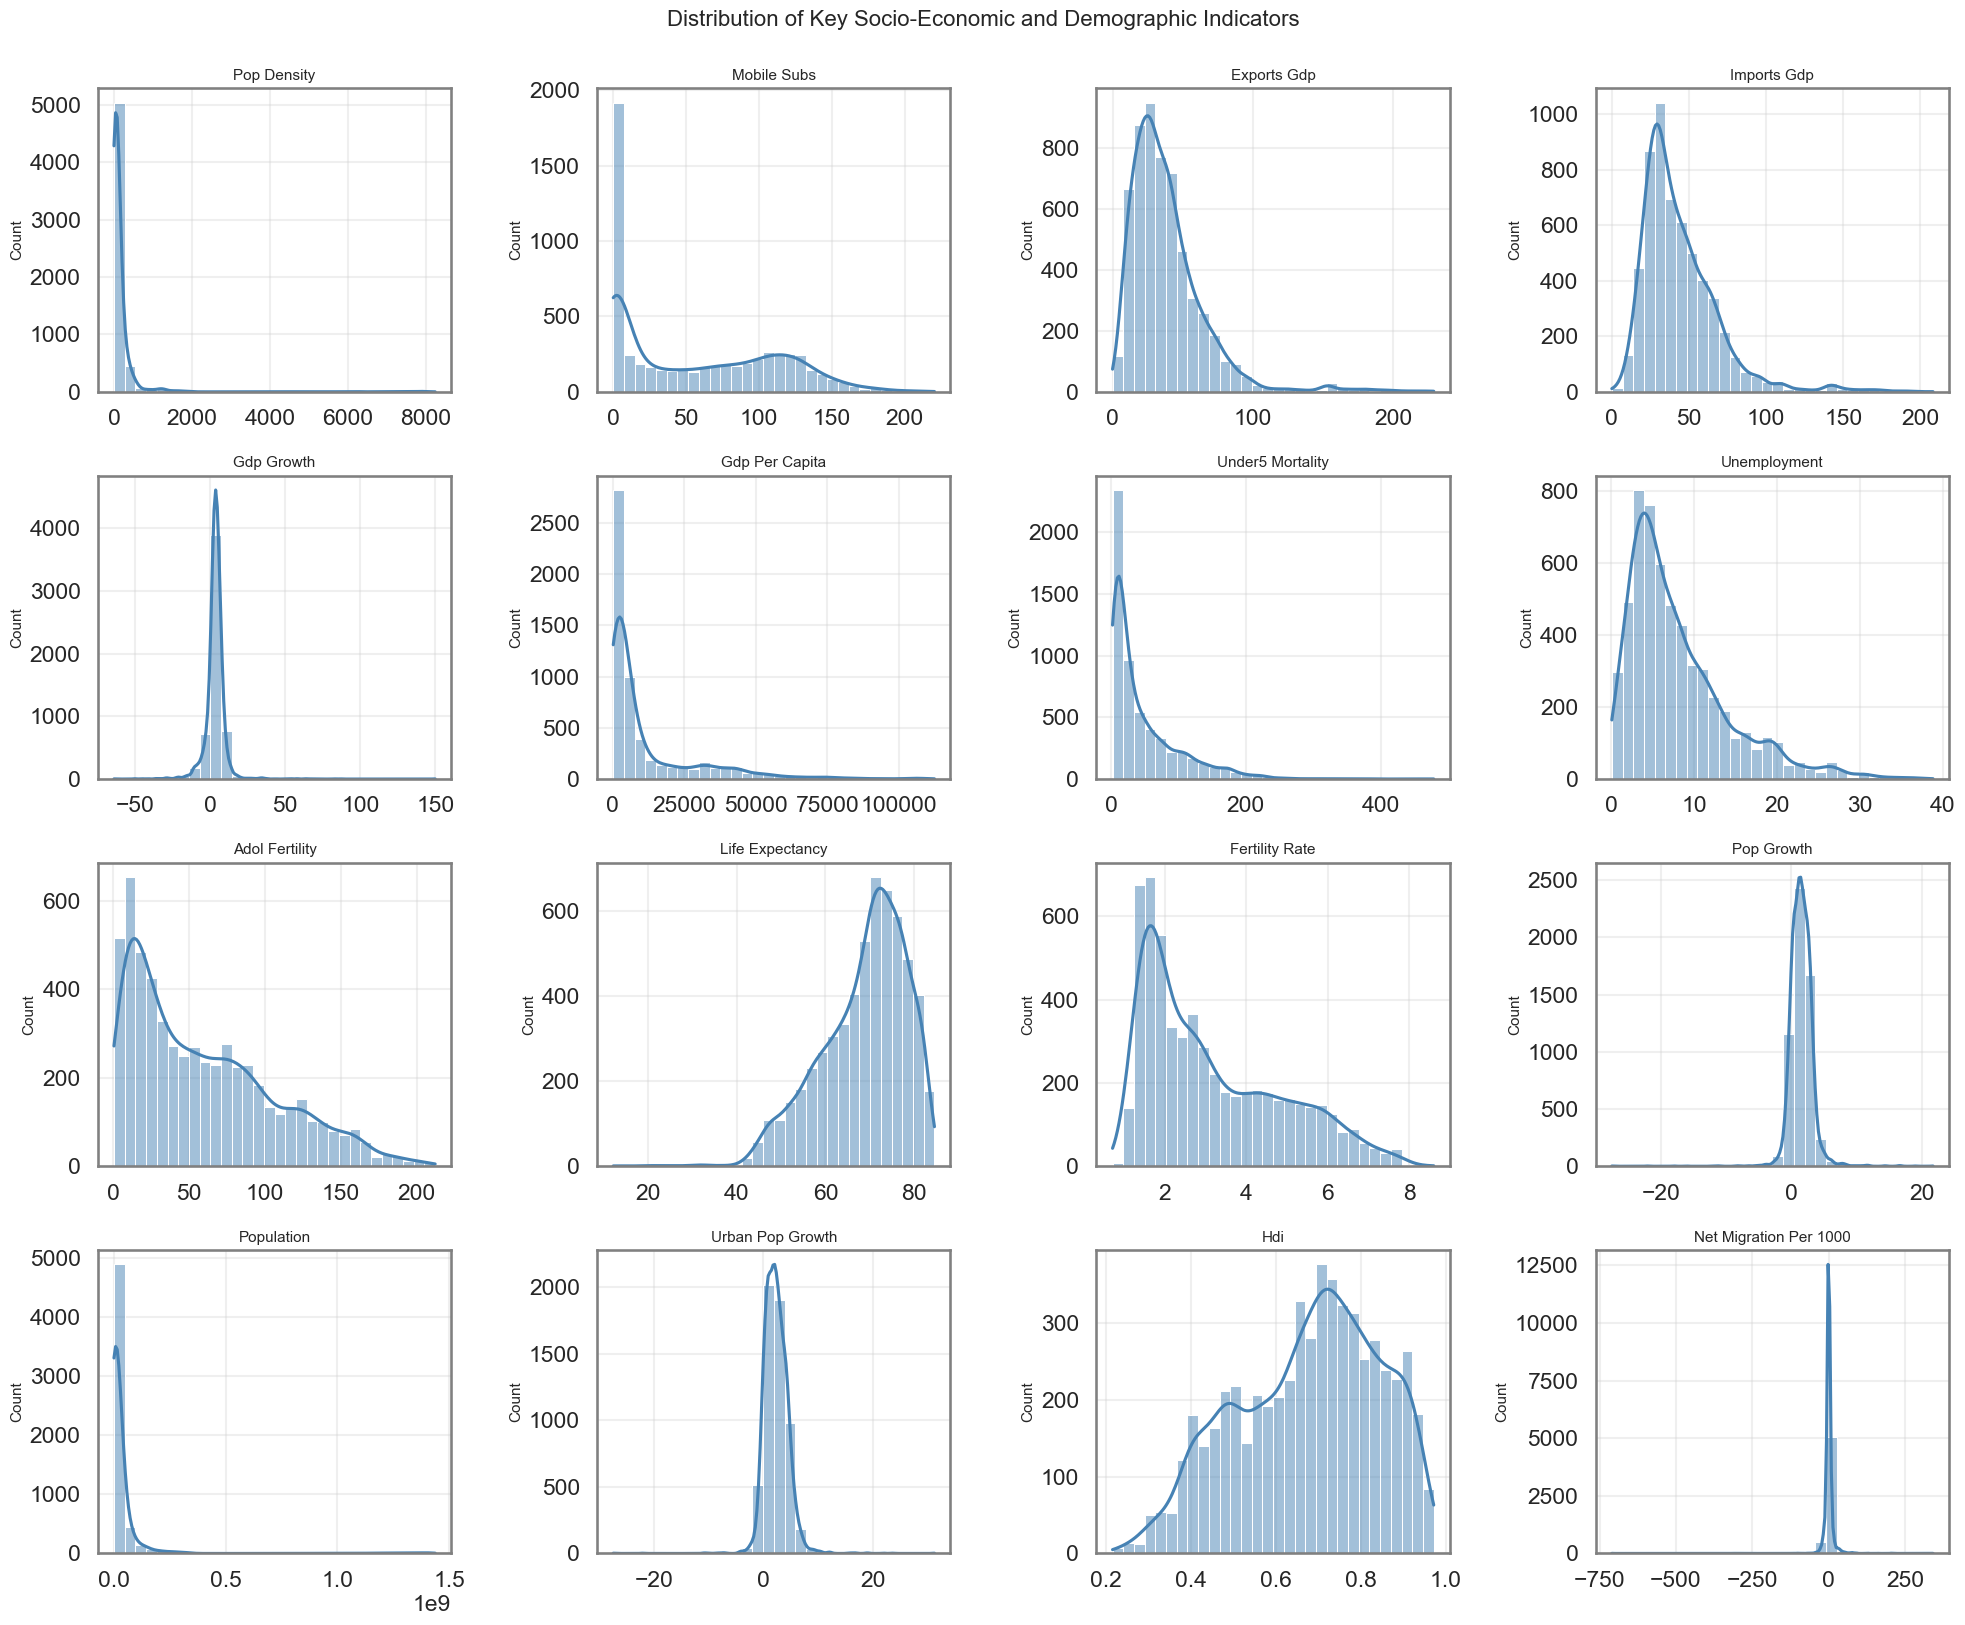

In [4]:
import math
numeric_cols = [
    'pop_density', 'mobile_subs', 'exports_gdp', 'imports_gdp',
    'gdp_growth', 'gdp_per_capita', 'under5_mortality', 'unemployment',
    'adol_fertility', 'life_expectancy', 'fertility_rate', 'pop_growth',
    'population', 'urban_pop_growth', 'hdi', 'net_migration_per_1000'
]

n_cols = 4
n_rows = math.ceil(len(numeric_cols) / n_cols)
plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_country[col], kde=True, bins=30, color="steelblue")
    plt.title(col.replace('_', ' ').title(), fontsize=11)
    plt.xlabel("")
plt.tight_layout()
plt.suptitle("Distribution of Key Socio-Economic and Demographic Indicators", fontsize=16, y=1.02)
plt.show()

---

## 3. Focus on Net Migration (per 1,000 People)

> **Interpretation tip:** The distribution is highly concentrated around zero, with a small set of countries
exhibiting extreme inflows (e.g., Gulf states) or outflows (e.g., conflict-affected nations).

### 3.1 Distribution of Net Migration Rates

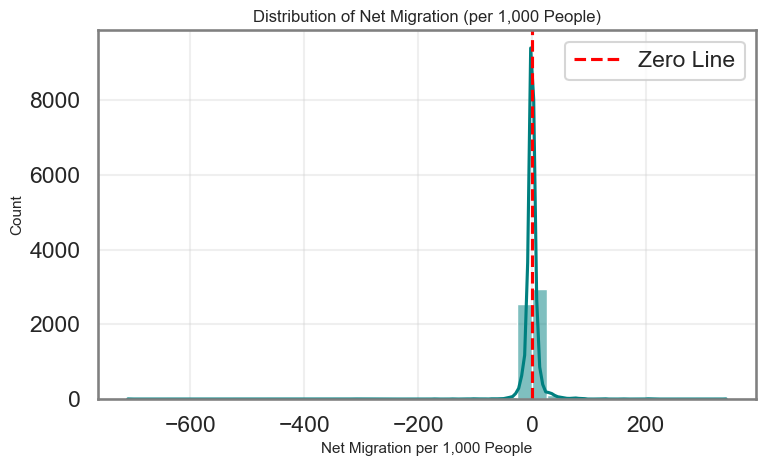

,Value
count,5712.000000
mean,0.008882
std,17.733863
min,-709.898215
1%,-29.145429
5%,-14.879145
50%,-0.294753
95%,14.405584
99%,44.691864
max,340.852702


In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df_country["net_migration_per_1000"], kde=True, bins=40, color="teal")
plt.title("Distribution of Net Migration (per 1,000 People)")
plt.xlabel("Net Migration per 1,000 People")
plt.axvline(0, color='red', linestyle='--', label="Zero Line")
plt.legend()
plt.tight_layout()
plt.show()

df_country["net_migration_per_1000"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame("Value")

### 3.2 Global Trend Over Time

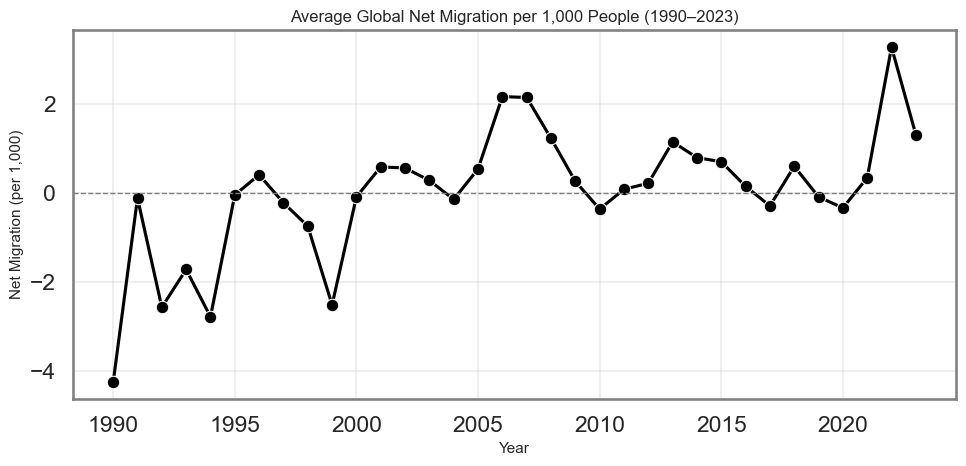

In [6]:
global_trend = df_country.groupby("year")["net_migration_per_1000"].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=global_trend, x="year", y="net_migration_per_1000", marker="o", color="black")
plt.title("Average Global Net Migration per 1,000 People (1990–2023)")
plt.xlabel("Year"); plt.ylabel("Net Migration (per 1,000)")
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.tight_layout(); plt.show()

### 3.3 Country-Level Variation

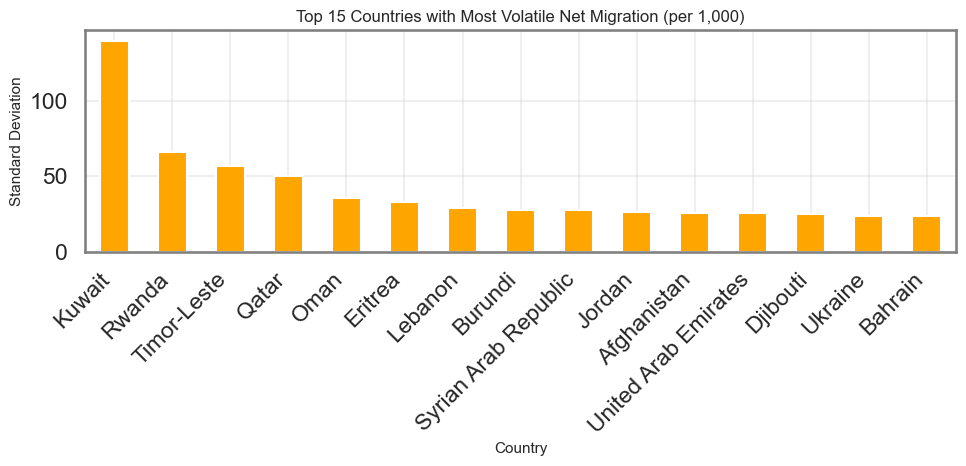

In [7]:
migration_variability = (
    df_country.groupby("Country Name")["net_migration_per_1000"].std().sort_values(ascending=False)
)
plt.figure(figsize=(10,5))
migration_variability.head(15).plot(kind='bar', color='orange')
plt.title("Top 15 Countries with Most Volatile Net Migration (per 1,000)")
plt.ylabel("Standard Deviation"); plt.xlabel("Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

### 3.4 Top Migration Inflows and Outflows (Average 1990–2023)

,"Average per 1,000",Type
Country Name,,
Tonga,-20.43,Outflow
Samoa,-17.41,Outflow
Moldova,-16.12,Outflow
Albania,-14.14,Outflow
Georgia,-13.71,Outflow
Guyana,-13.42,Outflow
El Salvador,-10.87,Outflow
Fiji,-10.09,Outflow
Armenia,-10.00,Outflow


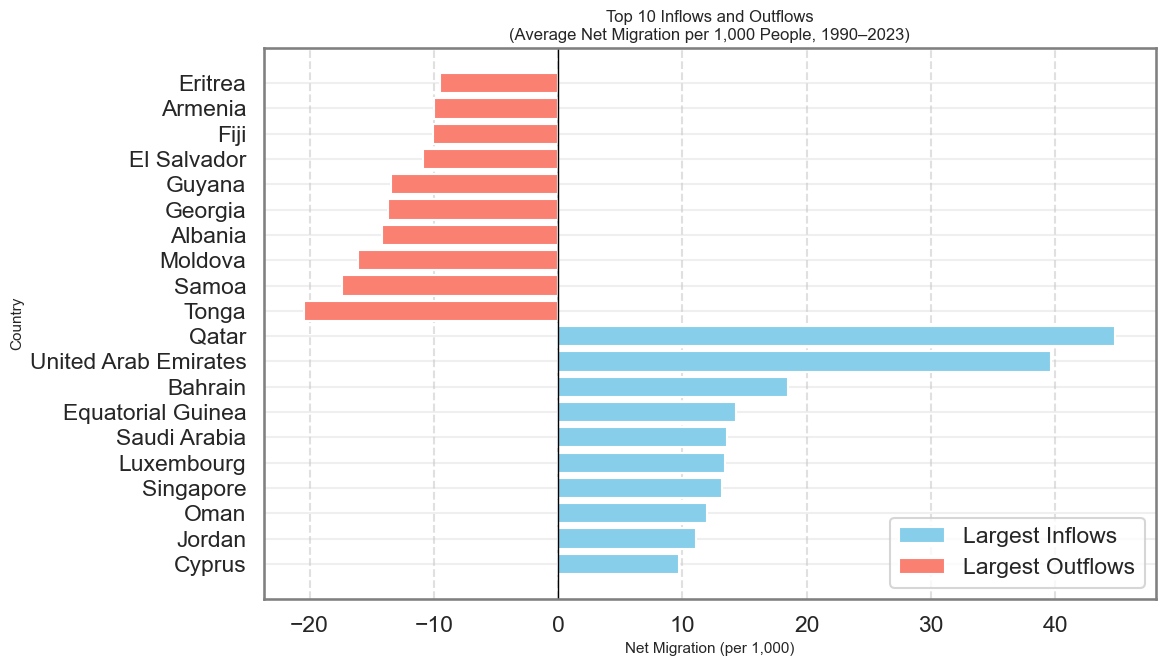

In [8]:
avg_migration = (
    df_country.groupby("Country Name")["net_migration_per_1000"].mean().sort_values()
)
top_inflows = avg_migration.tail(10)
top_outflows = avg_migration.head(10)

top_summary = pd.concat([
    top_outflows.rename("Average per 1,000").to_frame().assign(Type="Outflow"),
    top_inflows.rename("Average per 1,000").to_frame().assign(Type="Inflow")
])
display(top_summary.round(2))

plt.figure(figsize=(12,7))
plt.barh(top_inflows.index, top_inflows, color="skyblue", label="Largest Inflows")
plt.barh(top_outflows.index, top_outflows, color="salmon", label="Largest Outflows")
plt.axvline(0, color="black", linewidth=1)
plt.title("Top 10 Inflows and Outflows\n(Average Net Migration per 1,000 People, 1990–2023)")
plt.xlabel("Net Migration (per 1,000)"); plt.ylabel("Country")
plt.legend(loc="lower right", frameon=True)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

---

## 4. Global vs Regional Migration Trends

> Uses the **aggregates dataset** (`df_agg`) to show how regional and income-group averages compare to the global mean.

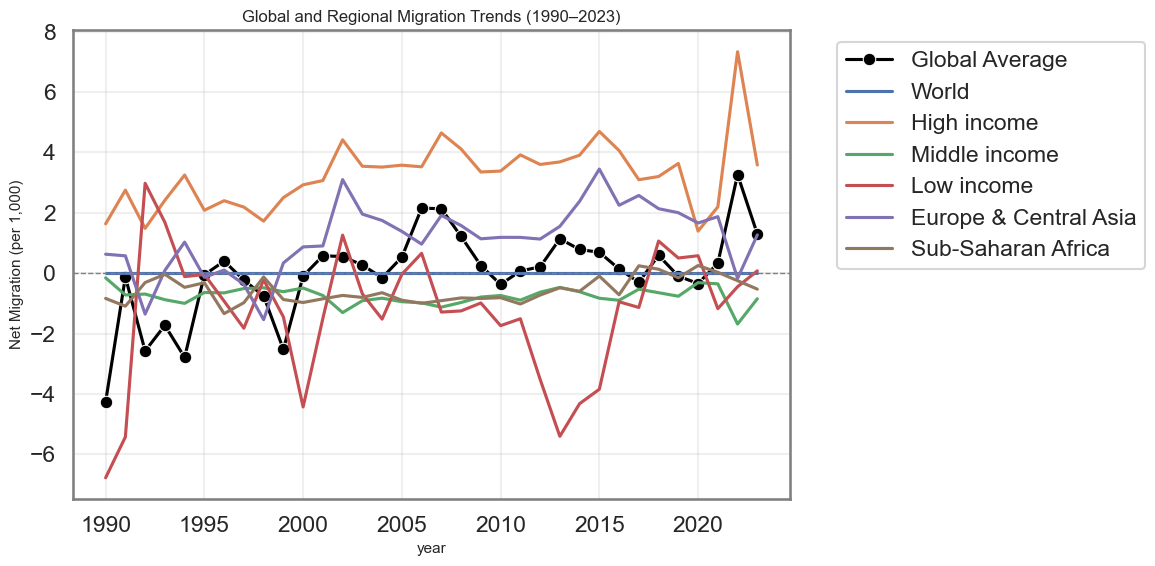

In [9]:
# Prepare regional/income-group trends
agg_trends = (
    df_agg.groupby(["Country Name", "year"])["net_migration_per_1000"].mean().reset_index()
)
key_aggregates = [
    "World", "High income", "Middle income", "Low income",
    "Europe & Central Asia", "Sub-Saharan Africa"
]
plt.figure(figsize=(12,6))
sns.lineplot(data=df_country.groupby("year")["net_migration_per_1000"].mean().reset_index(),
             x="year", y="net_migration_per_1000", marker="o", color="black", label="Global Average")
for region in key_aggregates:
    sub = agg_trends[agg_trends["Country Name"] == region]
    if not sub.empty:
        sns.lineplot(data=sub, x="year", y="net_migration_per_1000", label=region)
plt.axhline(0, color="gray", linestyle="--", lw=1)
plt.title("Global and Regional Migration Trends (1990–2023)")
plt.ylabel("Net Migration (per 1,000)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout(); plt.show()

---

## 5. Correlation and Feature Relationships

### 5.1 Heatmap of Key Correlations

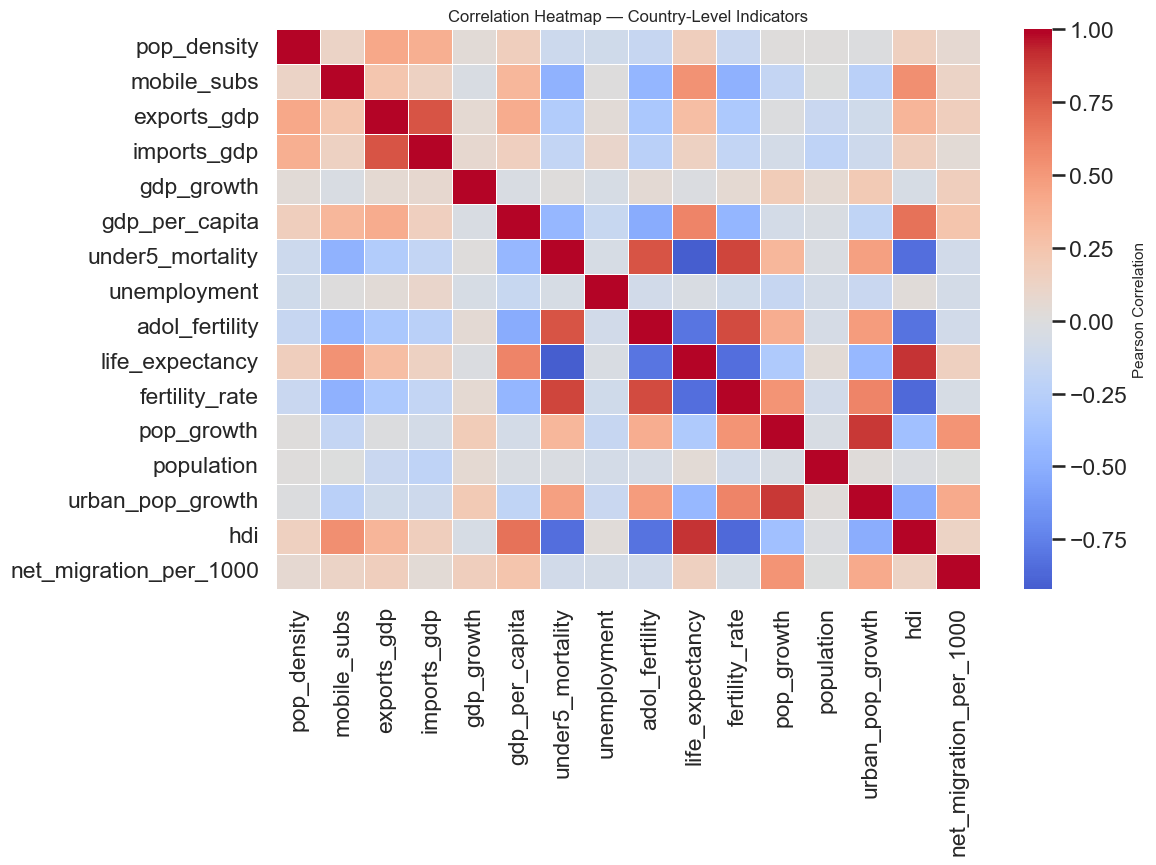

In [10]:
corr_cols = [c for c in numeric_cols if c in df_country.columns]
corr = df_country[corr_cols].corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False,
            cbar_kws={"label": "Pearson Correlation"}, linewidths=0.5)
plt.title("Correlation Heatmap — Country-Level Indicators")
plt.tight_layout(); plt.show()

### 5.2 Top Associations with Net Migration

In [11]:
corr_target = corr["net_migration_per_1000"].sort_values(ascending=False)
print("Top positive correlations with net migration per 1,000:")
display(corr_target.head(6).to_frame("Correlation").round(3))
print("\nTop negative correlations with net migration per 1,000:")
display(corr_target.tail(6).to_frame("Correlation").round(3))

Top positive correlations with net migration per 1,000:


,Correlation
net_migration_per_1000,1.000
pop_growth,0.527
urban_pop_growth,0.413
gdp_per_capita,0.244
exports_gdp,0.167
gdp_growth,0.166



Top negative correlations with net migration per 1,000:


,Correlation
imports_gdp,0.043
population,0.001
fertility_rate,-0.057
unemployment,-0.079
adol_fertility,-0.090
under5_mortality,-0.092


---

## 6. Country-Level Trends

To illustrate group-level patterns, we examine nine representative countries:

- **Conflict-driven outflows:** Ukraine, Syrian Arab Republic, Sudan, Afghanistan  
- **Transit/mixed economies:** Turkiye, Cyprus  
- **Destination economies:** United Arab Emirates, Qatar, Germany

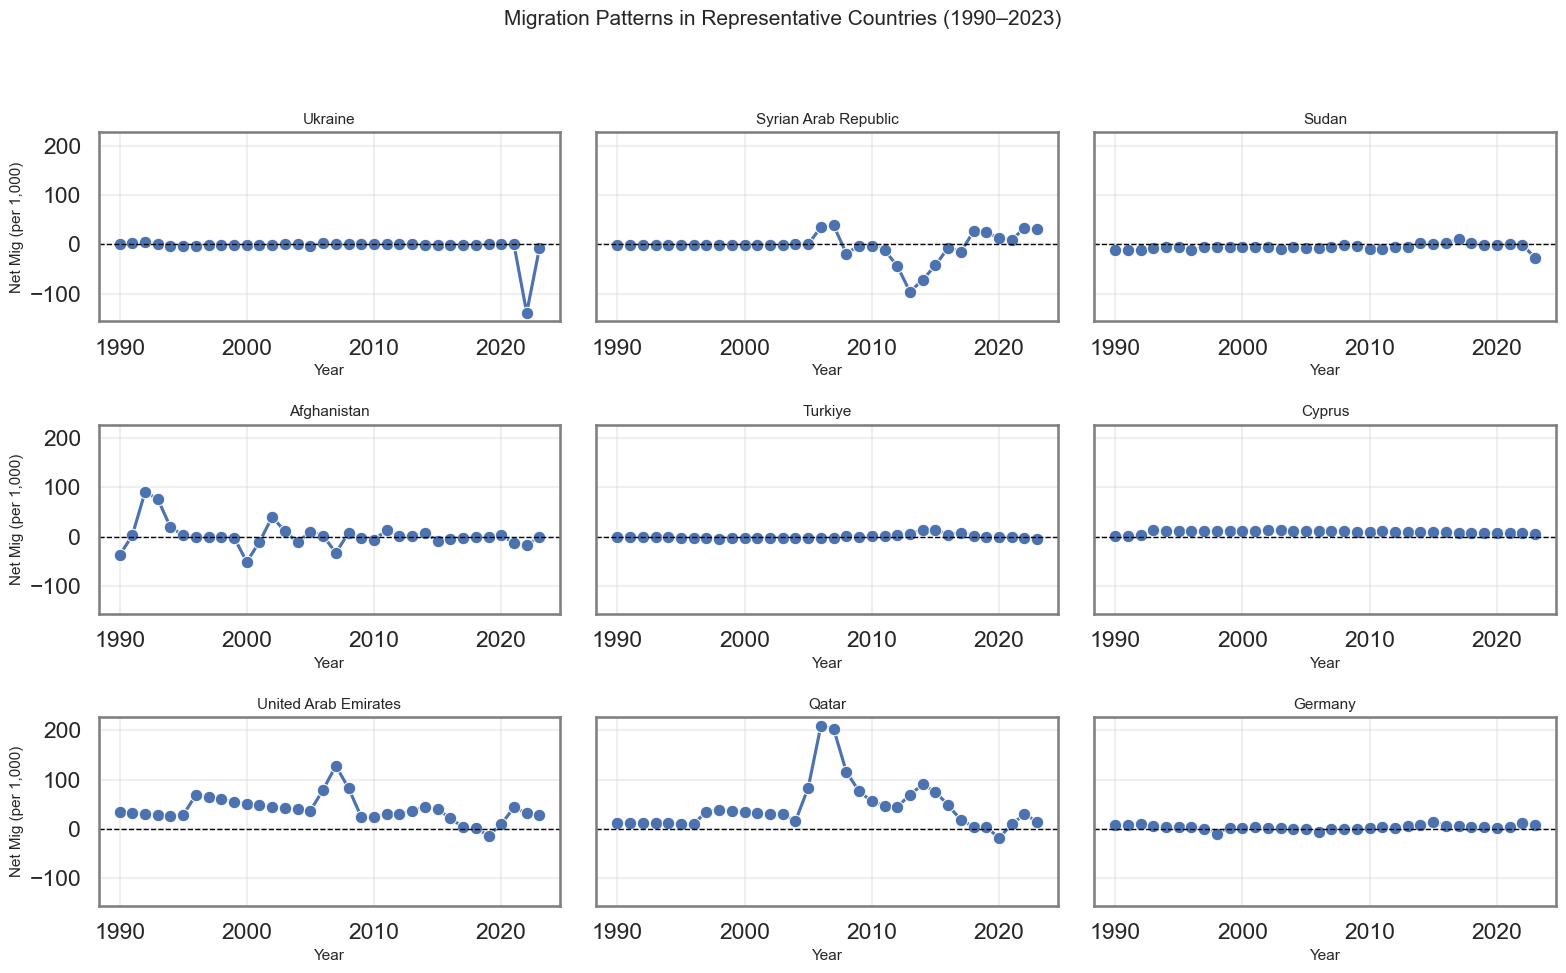

In [12]:
countries_show = [
    "Ukraine", "Syrian Arab Republic", "Sudan",
    "Afghanistan", "Turkiye", "Cyprus",
    "United Arab Emirates", "Qatar", "Germany"
]

fig, axes = plt.subplots(3, 3, figsize=(16, 10), sharey=True)
axes = axes.flatten()
for i, country in enumerate(countries_show):
    sub = df_country[df_country["Country Name"] == country]
    if not sub.empty:
        sns.lineplot(ax=axes[i], data=sub, x="year", y="net_migration_per_1000", marker="o")
        axes[i].axhline(0, color="black", linestyle="--", lw=1)
        axes[i].set_title(country, fontsize=11)
        axes[i].set_xlabel("Year"); axes[i].set_ylabel("Net Mig (per 1,000)")
    else:
        axes[i].set_visible(False)

plt.suptitle("Migration Patterns in Representative Countries (1990–2023)", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

---

## 7. Key Insights Summary

- Net migration is **highly polarized**: most countries cluster near zero, while a small set exhibits persistent inflows/outflows.  
- **Conflict-affected** states (Ukraine, Syria, Sudan, Afghanistan) show sustained negative migration.  
- **High-income destinations** (UAE, Qatar; Germany in absolute terms) maintain positive net migration rates.  
- Economic and demographic indicators (e.g., **HDI, GDP per capita, fertility**) show the strongest relationships with migration.  

→ The dataset is now ready for **feature engineering and predictive modeling** in the next notebook.